<a href="https://colab.research.google.com/github/tjturnage/satellite/blob/master/Satellite_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <font size="+4" color="green"><b>GOES Satellite Image Mosaics</b></font>  
<font size="+1" color="gray"><i>updated Aug 14, 2024</i></font>

---
Questions or bugs? Please contact me at thomas.turnage@noaa.gov

---

<font size="+2">**Allows the user to plot GOES satellite images and RGBs**</font>

<font size="+1">*The code borrows heavily from:*</font>
<ul>
<li>this <a href="https://lsterzinger.medium.com/add-lat-lon-coordinates-to-goes-16-goes-17-l2-data-and-plot-with-cartopy-27f07879157f" target="_blank">medium article</a> showing how to slice satellite data by lat/lon coordinates</li>
<li>The <a href="https://goes2go.readthedocs.io/en/latest/" target="_blank">goes2go</a> library developed by <a href="https://github.com/blaylockbk" target="_blank">Brian Blaylock</a> including <a href="https://goes2go.readthedocs.io/en/latest/reference_guide/index.html#rgb-recipes" target="_blank">RGB recipes</a></li>
<li>The <a href="https://unidata.github.io/MetPy/latest/index.html" target="_blank">MetPy</a> collection of tools
</ul>


<font size="+1">*Recent Updates*</font>
*   Fixed error that occurs when just one panel is chosen
*   Can now manually set plot dimensions and aspect ratio
*   Future work - add GLM data, mesosectors

<hr>



In [ ]:
# @title <font size="+3" color="green">Install software and datasets, define functions</font><br><i>(This takes a while but only needs to be done once! )
print("Installing Packages ...")

import warnings
warnings.filterwarnings('ignore')
!pip install s3fs &> /dev/null
!pip install pyproj &> /dev/null
!pip install xarray &> /dev/null
!pip install cartopy &> /dev/null
!pip install MetPy &> /dev/null
!pip install goes2go &> /dev/null
!apt install imagemagick &> /dev/null

print("Installations Complete!")

import os
import glob
import s3fs
from pyproj import Proj
import xarray as xr
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime,timezone,timedelta
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl

print("Library Imports Complete!")

#---------------------------------------------------------------------
#   The following functions that calculate lat/lon coordinate values and then add
#   these dimensions to the xarray come from:
#
#   https://lsterzinger.medium.com/add-lat-lon-coordinates-to-goes-16-goes-17-l2-data-and-plot-with-cartopy-27f07879157f
#---------------------------------------------------------------------

def calc_latlon(ds):
    # The math for this function was taken from
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection

    x,y = np.meshgrid(x,y)

    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat

    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2

    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)

    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)



    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds


def get_xy_from_latlon(ds, lats, lons):

    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data

    x = ds.x.data
    y = ds.y.data

    x,y = np.meshgrid(x,y)

    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]

    return ((min(x), max(x)), (min(y), max(y)))


#---------------------------------------------------------------------
#   The following functions were adapted from:
#   https://github.com/blaylockbk/goes2go/blob/main/goes2go/rgb.py
#---------------------------------------------------------------------

def gamma_correction(a, gamma, verbose=False):
    """
    Darken or lighten an image with `gamma correction.

    <https://en.wikipedia.org/wiki/_gamma_correction>`_.

    Parameters
    ----------
    a : array-like
        An array of values, typically the RGB array of values in
        an image.
    gamma : float
        Gamma value to decode the image by.
        Values > 1 will lighten an image.
        Values < 1 will darken an image.
    """
    if verbose:
        if gamma > 1:
            print("Gamma Correction: 🌔 Lighten image")
        elif gamma < 1:
            print("Gamma Correction: 🌒 Darken image")
        else:
            print("Gamma Correction: 🌓 Gamma=1. No correction made.")
            return a

    # Gamma decoding formula
    return np.power(a, 1 / gamma)


def normalize(value, lower_limit, upper_limit, clip=True):
    """
    Normalize values between 0 and 1.

    Normalize between a lower and upper limit. In other words, it
    converts your number to a value in the range between 0 and 1.
    Follows `normalization formula
    <https://stats.stackexchange.com/a/70807/220885>`_

    This is the same concept as `contrast or histogram stretching
    <https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20162017/LectureNotes/IP/PointOperators/ImageStretching.html>`_


    .. code:: python

        NormalizedValue = (OriginalValue-LowerLimit)/(UpperLimit-LowerLimit)

    Parameters
    ----------
    value :
        The original value. A single value, vector, or array.
    upper_limit :
        The upper limit.
    lower_limit :
        The lower limit.
    clip : bool
        - True: Clips values between 0 and 1 for RGB.
        - False: Retain the numbers that extends outside 0-1 range.
    Output:
        Values normalized between the upper and lower limit.
    """
    norm = (value - lower_limit) / (upper_limit - lower_limit)
    if clip:
        norm = np.clip(norm, 0, 1)
    return norm


def FireTemperature(c07, c06, c05):
    """Create the Fire Temperature RGB.

    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/Fire_Temperature_RGB.pdf>`__ for reference)

    .. image:: /_static/FireTemperature.png


    """

    # Load the three channels into appropriate R, G, and B variables
    R = c07 + 273.15
    G = c06
    B = c05

    # _normalize each channel by the appropriate range of values (clipping happens in function)
    R = normalize(R, 273, 333)
    G = normalize(G, 0, 1)
    B = normalize(B, 0, 0.75)

    # Apply the gamma correction to Red channel.
    #   corrected_value = value^(1/gamma)
    gamma = 0.4
    R = gamma_correction(R, gamma)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def AirMass(c08,c10,c12,c13):
    """
    Air Mass RGB:
    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_AirMassRGB_final.pdf>`__ for reference)

    .. image:: /_static/AirMass.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """
    # Load the three channels into appropriate R, G, and B variables
    R = c08 - c10
    G = c12 - c13
    B = c08 + 273.15

    # Normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
    R = normalize(R, -26.2, 0.6)
    G = normalize(G, -42.2, 6.7)
    B = normalize(B, -64.65, -29.25)

    # Invert B
    B = 1 - B

    # The final RGB array :)
    RGB = np.dstack([R, G, B])
    return RGB

def DayCloudPhase(c13, c02, c05):
    """
    Day Cloud Phase Distinction RGB:
    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/Day_Cloud_Phase_Distinction.pdf>`__ for reference)

    .. image:: /_static/DayCloudPhase.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """
    # Load the three channels into appropriate R, G, and B variables
    # R = c13 + 273.15 ## thanks Brian Tentinger for catching this error
    R = c13
    G = c02
    B = c05

    # Normalize each channel by the appropriate range of values. (Clipping happens inside function)
    R = normalize(R, -53.5, 7.5)
    G = normalize(G, 0, 0.78)
    B = normalize(B, 0.01, 0.59)

    # Invert R
    R = 1 - R

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB


def DayConvection(c02, c05, c07, c08, c10, c13):
    """
    Day Convection RGB:
    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_DayConvectionRGB_final.pdf>`__ for reference)

    .. image:: /_static/DayConvection.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """
    # Load the three channels into appropriate R, G, and B variables
    # NOTE: Each R, G, B is a channel difference.
    R = c08 - c10
    G = c07 - c13
    B = c05 - c02

    # Normalize each channel by the appropriate range of values.
    R = normalize(R, -35, 5)
    G = normalize(G, -5, 60)
    B = normalize(B, -0.75, 0.25)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def DayCloudConvection(c02, c13):
    """Create the Day Cloud Convection RGB.

    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DayCloudConvectionRGB_final.pdf>`__ for reference)

    .. image:: /_static/DayCloudConvection.png

    """

    B = c13 + 273.15

    # _normalize each channel by the appropriate range of values.
    R = normalize(c02, 0, 1)
    G = normalize(c02, 0, 1)
    B = normalize(B, -70.15, 49.85)

    # Invert B
    B = 1 - B

    # Apply the gamma correction to Red channel.
    #   corrected_value = value^(1/gamma)
    gamma = 1.7
    R = gamma_correction(R, gamma)
    G = gamma_correction(G, gamma)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def DayLandCloud(c05,c03,c02):
    """Create the Day Land Cloud Fire RGB.

    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_daylandcloudRGB_final.pdf>`__ for reference)

    .. image:: /_static/DayLandCloud.png


    """

    # _normalize each channel by the appropriate range of values  e.g. R = (R-minimum)/(maximum-minimum)
    R = normalize(c05, 0, 0.975)
    G = normalize(c03, 0, 1.086)
    B = normalize(c02, 0, 1)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def DayLandCloudFire(c06, c03, c02):
    """
    Day Land Cloud Fire RGB:
    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_DayLandCloudFireRGB_final.pdf>`__ for reference)

    .. image:: /_static/DayLandCloudFire.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """

    # Normalize each channel by the appropriate range of values  e.g. R = (R-minimum)/(maximum-minimum)
    R = normalize(c06, 0, 1)
    G = normalize(c03, 0, 1)
    B = normalize(c02, 0, 1)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def SimpleWaterVapor(c13, c08, c10):
    """Create the Simple Water Vapor RGB.

    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/Simple_Water_Vapor_RGB.pdf>`__ for reference)

    .. image:: /_static/WaterVapor.png


    """
    #R = c13
    #G = c08
    #B = c10

    # _normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
    R = normalize(c13, -70.86, 5.81)
    G = normalize(c08, -58.49, -30.48)
    B = normalize(c10, -28.03, -12.12)

    # Invert the colors
    R = 1 - R
    G = 1 - G
    B = 1 - B

    # The final RGB array :)
    RGB = np.dstack([R, G, B])


    return RGB


def DifferentialWaterVapor(c08,c10):
    """
    Differential Water Vapor RGB:
    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_DifferentialWaterVaporRGB_final.pdf>`__ for reference)

    .. image:: /_static/DifferentialWaterVapor.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """
    # Load the three channels into appropriate R, G, and B variables.
    R = c10 - c08
    G = c10 + 273.15
    B = c08 + 273.15

    # Normalize each channel by the appropriate range of values. e.g. R = (R-minimum)/(maximum-minimum)
    R = normalize(R, -3, 30)
    G = normalize(c10, -60, 5)
    B = normalize(c08, -64.65, -29.25)

    # Gamma correction
    Rgamma = 0.2587
    R = np.power(R, 1 / Rgamma)

    GBgamma = 0.4
    G = np.power(G, 1 / GBgamma)
    B = np.power(B, 1 / GBgamma)

    # Invert the colors
    R = 1 - R
    G = 1 - G
    B = 1 - B

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def DaySnowFog(c03,c05,c07,c13):
    """Day Snow-Fog RGB.

    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_DaySnowFog.pdf>`__ for reference)

    .. image:: /_static/DaySnowFog.png


    """

    # Load the three channels into appropriate R, G, and B variables
    R = c03
    G = c05
    B = c07 - c13

    # _normalize values
    R = normalize(R, 0, 1)
    G = normalize(G, 0, 0.7)
    B = normalize(B, 0, 30)

    # Apply a gamma correction to the image
    gamma = 1.7
    R = gamma_correction(R, gamma)
    G = gamma_correction(G, gamma)
    B = gamma_correction(B, gamma)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def NighttimeMicrophysics(c07,c13,c15):
    """
    Nighttime Microphysics RGB:
    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/QuickGuide_GOESR_NtMicroRGB_final.pdf>`__ for reference)

    .. image:: /_static/NighttimeMicrophysics.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """
    # Load the three channels into appropriate R, G, and B variables
    R = c15 - c13
    G = c13 - c07
    B = c13

    # Normalize values
    R = normalize(R, -6.7, 2.6)
    G = normalize(G, -3.1, 5.2)
    B = normalize(B, -29.6, 19.5)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB


def Dust(c11, c13, c14, c15):
    """Create the SulfurDioxide RGB.

    (See `Quick Guide <http://rammb.cira.colostate.edu/training/visit/quick_guides/Dust_RGB_Quick_Guide.pdf>`__ for reference)

    .. image:: /_static/Dust.png


    """

    # Load the three channels into appropriate R, G, and B variables
    R = c15 - c13
    G = c14 - c11
    B = c13 # original function subtracts 273.15, but already did this

    # _normalize values
    R = normalize(R, -6.7, 2.6)
    G = normalize(G, -0.5, 20)
    B = normalize(B, -11.95, 15.55)

    # Apply a gamma correction to the image
    gamma = 2.5
    G = gamma_correction(G, gamma)

    # The final RGB array :)
    RGB = np.dstack([R, G, B])

    return RGB

def SplitWindowDifference(c13, c15):
    """
    Split Window Difference RGB (greyscale):
    (See `Quick Guide <http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_SplitWindowDifference.pdf>`__ for reference)

    .. image:: /_static/SplitWindowDifference.png

    Parameters
    ----------
    C : xarray.Dataset
        A GOES ABI multichannel file opened with xarray.
    \*\*kwargs :
        Keyword arguments for ``rgb_as_dataset`` function.
        - latlon : derive latitude and longitude of each pixel

    """
    # Load the three channels into appropriate R, G, and B variables
    data = c15 - c13

    # Normalize values
    data = normalize(data, -10, 10)

    # The final RGB array :)
    RGB = np.dstack([data, data, data])

    return RGB

def NightFogDifference(c07,c13):
    """Night Fog Difference RGB (greyscale).

    (See `Quick Guide <http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_NightFogBTD.pdf>`__ for reference)

    .. image:: /_static/NightFogDifference.png


    """

    # Load the three channels into appropriate R, G, and B variables
    data = c13 - c07

    # _normalize values
    data = normalize(data, -90, 15)

    # Invert data
    data = 1 - data

    # The final RGB array :)
    RGB = np.dstack([data, data, data])

    return RGB


#---------------------------------------------------------------------
#   These functions are my own :)
#---------------------------------------------------------------------

def extract_channels(subset):
    c01 = subset.CMI_C01.data
    plts['C01']['data'] = c01

    gamma = 2.2
    c02 = subset.CMI_C02.data
    c02gamma = np.power(c02,1/gamma)
    plts['C02']['data'] = c02gamma

    c03 = subset.CMI_C03.data
    plts['C03']['data'] = c03
    c04 = subset.CMI_C04.data
    plts['C04']['data'] = c04
    c05 = subset.CMI_C05.data
    plts['C05']['data'] = c05
    c06 = subset.CMI_C06.data
    plts['C06']['data'] = c06
    c07 = subset.CMI_C07.data - 273.15
    plts['C07']['data'] = c07
    c08 = subset.CMI_C08.data - 273.15
    plts['C08']['data'] = c08
    c09 = subset.CMI_C09.data - 273.15
    plts['C09']['data'] = c09
    c10 = subset.CMI_C10.data - 273.15
    plts['C10']['data'] = c10
    c11 = subset.CMI_C11.data - 273.15
    plts['C11']['data'] = c11
    c12 = subset.CMI_C12.data - 273.15
    plts['C12']['data'] = c12
    c13 = subset.CMI_C13.data - 273.15
    plts['C13']['data'] = c13
    c14 = subset.CMI_C14.data - 273.15
    plts['C14']['data'] = c14
    c15 = subset.CMI_C15.data - 273.15
    plts['C15']['data'] = c15

    RGB = FireTemperature(c07,c06,c05)
    plts['FireTemperature']['data'] = RGB

    RGB = AirMass(c08,c10,c12,c13)
    plts['AirMass']['data'] = RGB

    RGB = DayCloudPhase(c13,c02,c05)
    plts['DayCloudPhase']['data'] = RGB

    RGB = DayConvection(c02, c05, c07, c08, c10, c13)
    plts['DayConvection']['data'] = RGB

    RGB = DayCloudConvection(c02, c13)
    plts['DayCloudConvection']['data'] = RGB

    RGB = DayLandCloud(c05, c03, c02)
    plts['DayLandCloud']['data'] = RGB

    RGB = DayLandCloudFire(c06, c03, c02)
    plts['DayLandCloudFire']['data'] = RGB

    RGB = SimpleWaterVapor(c13, c08, c10)
    plts['SimpleWaterVapor']['data'] = RGB

    RGB = DifferentialWaterVapor(c08,c10)
    plts['DifferentialWV']['data'] = RGB

    RGB = DaySnowFog(c03,c05,c07,c13)
    plts['DaySnowFog']['data'] = RGB

    RGB = NighttimeMicrophysics(c07,c13,c15)
    plts['NightMicrophysics']['data'] = RGB

    RGB = Dust(c11,c13,c14,c15)
    plts['Dust']['data'] = RGB

    RGB = SplitWindowDifference(c13,c15)
    plts['SplitWindowDifference']['data'] = RGB

    RGB = NightFogDifference(c07,c13)
    plts['NightFogDifference']['data'] = RGB


    return


plts = {}
plts['C01'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Channel 01 Visible'}
plts['C02'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Channel 02 Visible'}
plts['C02i'] = {'cmap':'Greys_r','vmn':0,'vmx':18,'title':'Channel 02 Visible', 'latv': None, 'lonv': None}
plts['C03'] = {'cmap':'cod_ir','vmn':0,'vmx':1,'title':'Channel 3 Near-IR'}
plts['C04'] = {'cmap':'cod_ir','vmn':0,'vmx':1,'title':'Channel 4 Visible'}
plts['C05'] = {'cmap':'cod_ir','vmn':0,'vmx':1,'title':'Channel 5 Visible'}
plts['C06'] = {'cmap':'cod_ir','vmn':0,'vmx':1,'title':'Channel 6 IR'}
plts['C07'] = {'cmap':'cod_ir','vmn':0,'vmx':1,'title':'Channel 7 IR'}
plts['C08'] = {'cmap':'wv_cmap','vmn':-109.0,'vmx':0.0,'title':'Channel 8 W/V'}
plts['C09'] = {'cmap':'wv_cmap','vmn':-109.0,'vmx':0.0,'title':'Channel 9 W/V'}
plts['C10'] = {'cmap':'wv_cmap','vmn':-109.0,'vmx':0.0,'title':'Channel 10 W/V'}
plts['C11'] = {'cmap':'wv_cmap','vmn':-109.0,'vmx':0.0,'title':'Channel 11 W/V'}
plts['C12'] = {'cmap':'cod_ir','vmn':-110.0,'vmx':56.0,'title':'Channel 12 IR'}
plts['C13'] = {'cmap':'cod_ir','vmn':-110.0,'vmx':56.0,'title':'Channel 13 IR'}
plts['C14'] = {'cmap':'cod_ir','vmn':-110.0,'vmx':56.0,'title':'Channel 14 IR'}
plts['C15'] = {'cmap':'cod_ir','vmn':-110.0,'vmx':56.0,'title':'Channel 15 IR'}
plts['ALL'] = {'cmap':'cod_ir','vmn':-110.0,'vmx':56.0,'title':'All'}
plts['FireTemperature'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Fire Temperature'}
plts['AirMass'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'AirMass'}
plts['DayCloudPhase'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Day Cloud Phase'}
plts['DayConvection'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Day Convection'}
plts['DayCloudConvection'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Day Cloud Convection'}
plts['DayLandCloud'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Day Land Cloud'}
plts['DayLandCloudFire'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Day Land Cloud Fire'}
plts['SimpleWaterVapor'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Simple Water Vapor'}
plts['DifferentialWV'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Differential W/V'}
plts['DaySnowFog'] = {'cmap':'Greys_r','vmn':-3,'vmx':3,'title':'Day Snow/Fog'}
plts['NightMicrophysics'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Nighttime Microphysics'}
plts['Dust'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Dust'}
plts['SplitWindowDifference'] = {'cmap':'Greys_r','vmn':-3,'vmx':3,'title':'Split Window Diff'}
plts['NightFogDifference'] = {'cmap':'Greys_r','vmn':0,'vmx':1,'title':'Night Fog Difference'}

def create_and_register_cmap(cmap_name, original_colors, position, rgb_input=True):
    """
    1) Converts list of color values from 8-bit (0-255 scale)
       to 0-1 decimal scale.

    2) The created final_color_list is combine with position list
       to create a matplotlib colormap.

    3) Registers the new colormap using the supplied cmap_name.

    Input
    ----------
             cmap_name : string
                         Name of the cmap you want to use and register

      original_ colors : list
                         8-bit tuples containing RGB values
                         example: [(127,256,192), (125,125,125)]

              position : list
                         node locations for color break points on
                         a 0 to 1 scale

            rgb_input : boolean
                        True: Color conversion from RGB to performed.
                       False: Color conversion from RGB is skipped.

    Returns
    -------
    None

    """
    if rgb_input:
        final_color_list = []
        for color in original_colors:
            converted_color_group = []
            for original_channel_value in color:
                new_channel_value = float(original_channel_value)/255
                converted_color_group.append(float(format(new_channel_value, '.3f')))
            converted_color_tuple = tuple(converted_color_group)
            final_color_list.append(converted_color_tuple)
    else:
        final_color_list = original_colors

    this_cmap = LinearSegmentedColormap.from_list(cmap_name, list(zip(position, final_color_list)))
    mpl.colormaps.register(cmap=this_cmap, force=True)
    return


###############################################################################

#---------------  CH13 (clean IR) ----------------
# Using COD version
ir_colors = [(0,0,0),(255,255,255),(255,0,0), (255,255,0), (0,255,0), (0,0,255),
 (191,0,255), (255,255,255),(120,120,120),(0,0,0)]
ir_nodes = [0, 10/166, 45/166, 55/166, 65/166, 82/166, 90/166, 95/166, 136/166,
            1]
create_and_register_cmap('cod_ir', ir_colors, ir_nodes)

#--------------- WV CH08,CH09,CH10 ---------------
wv_colors = [(0,255,255),(0,110,0),(255,255,255),(0,0,165),(255,255,0),
 (255,0,0),(0, 0, 0)]
wv_nodes = [0, (109-75)/109,(109-47)/109, (109-30)/109, (109-15.5)/109,
            108/109,1 ]
create_and_register_cmap('wv_cmap', wv_colors, wv_nodes)


#--------------- Winter Ref ----------------------
winter_rgbs = [(0, 0, 0), (0, 0, 0), (70, 70, 70), (255, 255, 255),
(0, 80, 255), (0, 0, 160), (0, 0, 60), (255, 255, 0), (220, 100, 0),
(220, 100, 0), (220, 100, 0)]
winter_nodes = [0.0, 0.0984, 0.2213, 0.3361, 0.3689, 0.4098, 0.4918, 0.5246,
                0.5902, 0.918, 1.0]
create_and_register_cmap('winter_z', winter_rgbs, winter_nodes)

#--------------- WDTD Ref ----------------------
wdtd_z_rgbs =[(0, 0, 0), (0, 0, 0), (130, 130, 130), (95, 189, 207),
(57, 201, 105), (57, 201, 105), (0, 40, 0), (9, 94, 9), (255, 207, 0),
(255, 207, 0), (255, 133, 0), (255, 0, 0), (89, 0, 0), (255, 245, 255),
(225, 11, 227), (164, 0, 247), (99, 0, 214), (5, 221, 224), (58, 103, 181),
(255, 255, 255), (255, 255, 255)]
wdtd_z_nodes = [0.0, 0.0164, 0.3844, 0.3852, 0.4254, 0.4262, 0.5484, 0.5492,
                0.5893, 0.5902, 0.6713, 0.6721, 0.7533, 0.7541, 0.8352, 0.8361,
                0.8762, 0.877, 0.9172, 0.918, 1.0]
create_and_register_cmap('wdtd_z', wdtd_z_rgbs, wdtd_z_nodes)


################################################################################

import urllib.request
import requests
from bs4 import BeautifulSoup
import zipfile

url = "https://www.weather.gov/gis/Counties"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
zip_links = soup.find_all("a", href=lambda href: href.endswith(".zip"))
if zip_links:
    zip_url = zip_links[-1]["href"]
    counties_url = os.path.join('https://www.weather.gov',str(zip_url)[1:])
    zip_file_name = counties_url.split("/")[-1]
    zip_file_root = zip_file_name[:-4]
    shapefile_name = f'{zip_file_root}.shp'
else:
    print("No zip files found on the website.")

if os.path.exists('/content/counties.zip') is False:
  urllib.request.urlretrieve(counties_url, "counties.zip")
with zipfile.ZipFile('counties.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

try:
  COUNTY_SHAPEFILE
except NameError:
  reader = shpreader.Reader(shapefile_name)
  features = list(reader.geometries())
  COUNTY_SHAPEFILE = cfeature.ShapelyFeature(features, ccrs.PlateCarree())

# download and read road shapefile
if os.path.exists('/content/roads.zip') is False:
  road_url = "https://www2.census.gov/geo/tiger/TIGER2019/PRIMARYROADS/tl_2019_us_primaryroads.zip"
  urllib.request.urlretrieve(road_url, "roads.zip")
with zipfile.ZipFile('roads.zip', 'r') as zip_roads:
    zip_roads.extractall('.')
try:
  ROAD_SHAPEFILE
except NameError:
  road_reader = shpreader.Reader("tl_2019_us_primaryroads.shp")
  features = list(road_reader.geometries())
  ROAD_SHAPEFILE = cfeature.ShapelyFeature(features, ccrs.PlateCarree())

Installing Packages ...
Installations Complete!
Library Imports Complete!


In [ ]:
# @title <font size="+3" color="green">Make Satellite, Time, Location, Selections</font>
start_date = None
start_hour = None
start_minute = None
end_date = None
end_hour = None
end_minute = None

# @markdown <font size="+2" color="blue"><b><i>Choose your satellite</i></b></font>
satellite = 'East (16)' # @param ['East (16)','West (17)', 'West (18)'] {type:"string"}

if satellite == 'East (16)':
  sat = 16
elif satellite == 'West (17)':
  sat = 17
else:
  sat = 18


# @markdown <font size="+2" color="blue"><b><i>Enter the start time (in UTC) for the plots</i></b></font>
start_date = "2024-07-19" # @param {type:"date"}
start_hour = 22 # @param {type:"slider", min:0, max:23, step:1}
start_minute = "00" # @param ["00","15","30","45"] {type:"string"}
# # @markdown <br><font color="blue"><h2>Enter the end time (in UTC) for the plots</h2></font>
# end_date = "2023-08-25" # @param {type:"date"}
# end_hour = 0 # @param {type:"slider", min:0, max:23, step:1}
# end_minute = "00" # @param ["00","15","30","45"] {type:"string"}

# @markdown <font size="+2" color="blue"><b><i>Enter the duration in hours and minutes</font><br><font color="blue">Example: 02 hours_duration, 30 plus_minutes = 2:30 duration</i></b></font><br><b>A long duration increases the risk of running out of memory, so consider making separate requests with shorter time ranges</b>
hours_duration = "00" # @param ["00","01","02","03","04","05","06"]
plus_minutes = "10" # @param ["00","10","20","30","40","50"]

if len(str(start_hour)) == 1:
  start_hour = f"0{start_hour}"
# if len(str(end_hour)) == 1:
#   end_hour = f"0{end_hour}"

data_start = f"{start_date} {start_hour}:{start_minute}"
# data_end = f"{end_date} {end_hour}:{end_minute}"

start_timeobj = datetime.strptime(data_start, '%Y-%m-%d %H:%M')
end_timeobj = start_timeobj + timedelta(hours=int(hours_duration),minutes=int(plus_minutes))
data_end = datetime.strftime(end_timeobj,'%Y-%m-%d %H:%M')
# data_end = f"{end_date} {end_hour}:{end_minute}"

# @markdown <font size="+2" color="blue"><b><i>Select time zone for labelling your figures</i></b></font>
time_zone = "MDT" # @param ["UTC", "EST", "EDT", "CST", "CDT", "MST", "MDT", "PST", "PDT"]
time_zone_dict = {"UTC": 0, "EST":5, "EDT":4, "CST":6, "CDT":5, "MST":7, "MDT":6, "PST":8, "PDT":7 }


# @markdown <font size="+2" color="blue"><b><i>Define plot boundaries in lat/lon coordinates</i></b></font>
west_edge = -106.0 # @param {type:"number"}
east_edge = -96.0 # @param {type:"number"}
south_edge = 42.0 # @param {type:"number"}
north_edge = 47.0 # @param {type:"number"}

plot_extent = [west_edge, east_edge, south_edge, north_edge]

# defines lat/lon range to slice data for plotting
# a larger area is needed for extra margin since the
# plot area gets sheared and warped during reprojection
lons = (plot_extent[0] - 1.5, plot_extent[1] + 1.5)
lats = (plot_extent[2] - 1.0, plot_extent[3] + 1.0)

# @markdown <font size="+2" color="blue"><b><i>Additional options</i></b></font>
plot_counties = True # @param {type:"boolean"}
plot_roads = True  # @param {type:"boolean"}
make_animation = False  # @param {type:"boolean"}

if plot_extent[1] - plot_extent[0] > 8:
  plot_counties = False

# <font size="+3" color="green">Satellite Channel / RGB References</font>
*   http://cimss.ssec.wisc.edu/goes/GOESR_QuickGuides.html
*   https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf
*   https://rammb2.cira.colostate.edu/training/visit/quick_reference/#tab17
*   https://www.goes-r.gov/mission/ABI-bands-quick-info.html  
  
<hr>
<br>  
<table>
<tr>
<td>
<table>
<tr>
<td colspan=2>
<font size="+2"><b>Individual Bands</font>
</td>
</tr>
<tr>
<td>C01</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band01.pdf" target="_blank">Blue Visible</a></td>
</tr>
<tr>
<td>C02</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band02.pdf" target="_blank">Red Visible</a></td>
</tr>
<tr>
<td>C02i</td>
<td>Hi-Res "Red" Visible (best for zoomed in displays)</td>
</tr>
<tr>
<td>C03</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band03.pdf" target="_blank">Veggie Band</a></td>
</tr>
<tr>
<td>C04</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band04.pdf" target="_blank">Cirrus Band</a></td>
</tr>
<tr>
<td>C05</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band05.pdf" target="_blank">Snow/Ice Near-IR</a></td>
</tr>
<tr>
<td>C06</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band06.pdf" target="_blank">Cloud Particle Size</a></td>
</tr>
<tr>
<td>C07</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band07.pdf" target="_blank">Shortwave Infrared</a></td>
</tr>
<tr>
<td>C08</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf" target="_blank">Upper-Level Tropospheric Water Vapor IR</a></td>
</tr>
<tr>
<td>C09</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf" target="_blank">Mid-Level Tropospheric Water Vapor IR</a></td>
</tr>
<tr>
<td>C10</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf" target="_blank">Lower-Level Tropospheric Water Vapor IR</a></td>
</tr>
<tr>
<td>C13</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band13.pdf" target="_blank">Clean IR Longwave Window</a></td>
</tr>
<tr>
<td>C14</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf" target="_blank">IR Longwave Window</a></td>
</tr>
<tr>
<td>C15</td>
<td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band15.pdf" target="_blank">"Dirty" IR Longwave</a></td>
</tr>
</table>

</td>

<td>
<font size="+2"><b>RGBs</b></font>
<table>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/VIIRS_Fire_Temperature_RGB_Quick_Guide_02052024.pdf" target="_blank">FireTemperature</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_AirMassRGB_final-1.pdf" target="_blank">Airmass</td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_DayCloudPhaseDistinction_final_v2.pdf" target="_blank">DayCloudPhase</td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_DayConvectionRGB_final-1.pdf" target="_blank">DayConvection</td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_DayCloudConvectionRGB_final-1.pdf" target="_blank">DayCloudConvection</td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_daylandcloudRGB_final-1.pdf" target="_blank">DayLandCloud</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_DayLandCloudFireRGB_final-1.pdf" target="_blank">DayLandCloudFire</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/Simple_Water_Vapor_RGB-1.pdf" target="_blank">SimpleWaterVapor</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_DifferentialWaterVaporRGB_final-1.pdf" target="_blank">DifferentialWV</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_DaySnowFogRGB_final_v2.pdf" target="_blank">DaySnowFog</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/QuickGuide_GOESR_NtMicroRGB_Final_20191206-1.pdf" target="_blank">NightMicrophysics</a></td></tr>
<tr><td><a href="https://rammb2.cira.colostate.edu/wp-content/uploads/2020/01/Dust_RGB_Quick_Guide-1.pdf" target="_blank">Dust</a></td></tr>
<tr><td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_SplitWindowDifference.pdf" target="_blank">SplitWindowDifference</a></td></tr>
<tr><td><a href="https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_NightFogBTD.pdf" target="_blank">NightFogDifference</a></td></tr>

</table>

</td>
</tr>
</table>

In [ ]:
# @title <font size="+3" color="green">Select Products to Plot and Define Plot Settings</font>
# @markdown <font size="+2" color="blue"><b><i>Choose up to 6 displays to plot</font>

pane1 = "DayCloudPhase" # @param ["None",'C01","C02","C02i","C03","C04","C05","C06","C07","C08","C09","C10","C11","C12","C13","C14","C15","FireTemperature","AirMass","DayCloudPhase","DayConvection","DayCloudConvection","DayLandCloud","DayLandCloudFire","SimpleWaterVapor","DifferentialWV","DaySnowFog","NightMicrophysics","Dust","SplitWindowDifference","NightFogDifference"]
pane2 = "None" # @param ["None",'C01","C02","C02i","C03","C04","C05","C06","C07","C08","C09","C10","C11","C12","C13","C14","C15","FireTemperature","AirMass","DayCloudPhase","DayConvection","DayCloudConvection","DayLandCloud","DayLandCloudFire","SimpleWaterVapor","DifferentialWV","DaySnowFog","NightMicrophysics","Dust","SplitWindowDifference","NightFogDifference"]
pane3 = "None" # @param ["None",'C01","C02","C02i","C03","C04","C05","C06","C07","C08","C09","C10","C11","C12","C13","C14","C15","FireTemperature","AirMass","DayCloudPhase","DayConvection","DayCloudConvection","DayLandCloud","DayLandCloudFire","SimpleWaterVapor","DifferentialWV","DaySnowFog","NightMicrophysics","Dust","SplitWindowDifference","NightFogDifference"]
pane4 = "None" # @param ["None",'C01","C02","C02i","C03","C04","C05","C06","C07","C08","C09","C10","C11","C12","C13","C14","C15","FireTemperature","AirMass","DayCloudPhase","DayConvection","DayCloudConvection","DayLandCloud","DayLandCloudFire","SimpleWaterVapor","DifferentialWV","DaySnowFog","NightMicrophysics","Dust","SplitWindowDifference","NightFogDifference"]
pane5 = "None" # @param ["None",'C01","C02","C02i","C03","C04","C05","C06","C07","C08","C09","C10","C11","C12","C13","C14","C15","FireTemperature","AirMass","DayCloudPhase","DayConvection","DayCloudConvection","DayLandCloud","DayLandCloudFire","SimpleWaterVapor","DifferentialWV","DaySnowFog","NightMicrophysics","Dust","SplitWindowDifference","NightFogDifference"]
pane6 = "None" # @param ["None",'C01","C02","C02i","C03","C04","C05","C06","C07","C08","C09","C10","C11","C12","C13","C14","C15","FireTemperature","AirMass","DayCloudPhase","DayConvection","DayCloudConvection","DayLandCloud","DayLandCloudFire","SimpleWaterVapor","DifferentialWV","DaySnowFog","NightMicrophysics","Dust","SplitWindowDifference","NightFogDifference"]

products = [p for p in (pane1,pane2,pane3,pane4,pane5,pane6) if p != "None"]

# @markdown <font size="+2" color="blue"><b><i>Keep this box checked for default plot settings<b></font>

use_default_plot_settings = False # @param {"type":"boolean"}

# @markdown <font size="+1" color="blue"><b><i>If NOT using default plot settings, make your selections below</b></font><br>Edit one or more of the following values - may require some testing<br><b><u>Limit figure size</u></b> so you don't run out of memory!</i></b></font>
# @markdown <ol><li><font color="blue">Adjust the width and height dimensions of the figure.</li>
# @markdown <li>Adjust the plot aspect ratio ... >1 shrinks horizontal scale and
# @markdown vice versa.</li></ol></font>


fig_height = 7 # @param {type:"slider", min:0, max:24, step:1}
fig_width = 18 # @param {type:"slider", min:0, max:24, step:1}

aspect_ratio = 1.25 # @param {type:"slider", min:0.25, max:3.5, step:0.25}

downloading satellite data from 2024-07-19 22:00 to 2024-07-19 22:10
 👮🏻‍♂️ File already exists. Do not overwrite: /content/sat_data/noaa-goes16/ABI-L1b-RadC/2024/201/22/OR_ABI-L1b-RadC-M6C01_G16_s20242012201182_e20242012203555_c20242012203597.nc
 👮🏻‍♂️ File already exists. Do not overwrite: /content/sat_data/noaa-goes16/ABI-L1b-RadC/2024/201/22/OR_ABI-L1b-RadC-M6C01_G16_s20242012206182_e20242012208555_c20242012208598.nc
 👮🏻‍♂️ File already exists. Do not overwrite: /content/sat_data/noaa-goes16/ABI-L1b-RadC/2024/201/22/OR_ABI-L1b-RadC-M6C02_G16_s20242012201182_e20242012203555_c20242012203579.nc
 👮🏻‍♂️ File already exists. Do not overwrite: /content/sat_data/noaa-goes16/ABI-L1b-RadC/2024/201/22/OR_ABI-L1b-RadC-M6C02_G16_s20242012206182_e20242012208555_c20242012208588.nc
 👮🏻‍♂️ File already exists. Do not overwrite: /content/sat_data/noaa-goes16/ABI-L1b-RadC/2024/201/22/OR_ABI-L1b-RadC-M6C03_G16_s20242012201182_e20242012203555_c20242012203590.nc
 👮🏻‍♂️ File already exists. Do not overwr

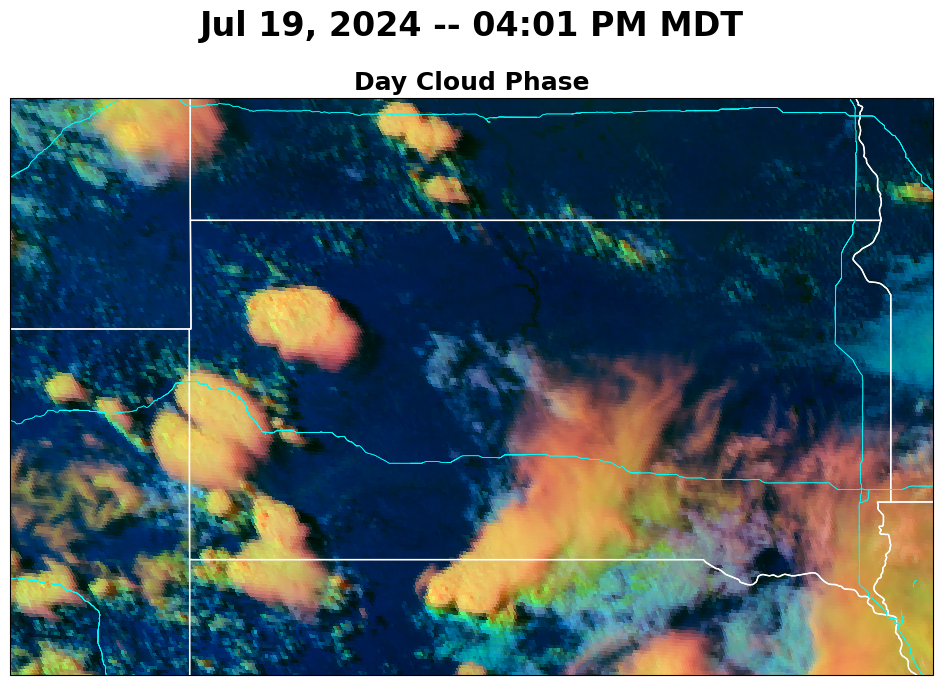

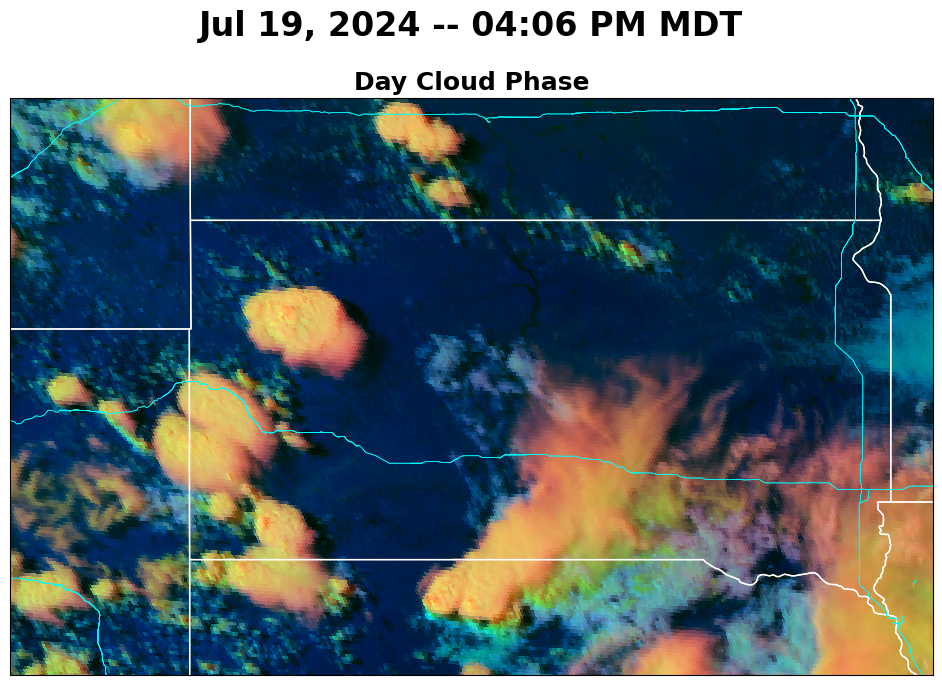

In [ ]:
# @title <font size="+3" color="green">Download satellite files then make plots</font>
for d in ('sat_data','images'):
  os.makedirs(os.path.join('/content',d), exist_ok=True)

from goes2go import GOES

if sat == 17:
  try:
    #GL = GOES(satellite=17, product="GLM-L2-LCFA", domain='C')
    GCONUS = GOES(satellite=17, product="ABI-L1b-RadC", domain='C')
    GCONUSALL = GOES(satellite=17, product="ABI-L2-MCMIPC", domain='C')
  except FileNotFoundError:
    print(f"GOES-{sat} not available, trying GOES-18 ...")
    #GL = GOES(satellite=18, product="GLM-L2-LCFA", domain='C')
    GCONUS = GOES(satellite=18, product="ABI-L1b-RadC", domain='C')
    GCONUSALL = GOES(satellite=18, product="ABI-L2-MCMIPC", domain='C')

elif sat == 18:
  try:
    #GL = GOES(satellite=18, product="GLM-L2-LCFA", domain='C')
    GCONUS = GOES(satellite=18, product="ABI-L1b-RadC", domain='C')
    GCONUSALL = GOES(satellite=18, product="ABI-L2-MCMIPC", domain='C')
  except FileNotFoundError:
    print(f"GOES-{sat} not available, trying GOES-17 ...")
    #GL = GOES(satellite=17, product="GLM-L2-LCFA", domain='C')
    GCONUS = GOES(satellite=17, product="ABI-L1b-RadC", domain='C')
    GCONUSALL = GOES(satellite=17, product="ABI-L2-MCMIPC", domain='C')

else:
    #GL = GOES(satellite=16, product="GLM-L2-LCFA", domain='C')
    GCONUS = GOES(satellite=sat, product="ABI-L1b-RadC", domain='C')
    GCONUSALL = GOES(satellite=sat, product="ABI-L2-MCMIPC", domain='C')

#GMESO = GOES(satellite=sat, product="ABI-L1b-RadC", domain='M')
df = GCONUS.df(start=data_start, end=data_end)
dfall = GCONUS.df(start=data_start, end=data_end)
print(f'downloading satellite data from {data_start} to {data_end}')
#GLM = GL.timerange(start=data_start, end=data_end, save_dir = '/content/sat_data' )
SAT = GCONUS.timerange(start=data_start, end=data_end, save_dir = '/content/sat_data' )
SATALL = GCONUSALL.timerange(start=data_start, end=data_end, save_dir = '/content/sat_data' )

VIS = SAT.query('band == 2')
VIS = VIS.reset_index(drop = True)

plts['C02i']['filelist'] = list(VIS['file'])
plts['ALL']['filelist'] = list(SATALL.file)

print("Now creating plots...")

def create_timestrings(ds):
    tstamp = datetime.strptime(ds.attrs['time_coverage_start'][:-3],'%Y-%m-%dT%H:%M:%S')
    local_time = tstamp - timedelta(hours=time_zone_dict[time_zone])
    local_timestamp = datetime.strftime(local_time, f'%b %d, %Y -- %I:%M %p {time_zone}')
    if time_zone == 'UTC':
      local_timestamp = datetime.strftime(local_time, f'%b %d, %Y -- %H:%M {time_zone}')
    pfname = datetime.strftime(tstamp, 'satellite-mosaic_%Y-%m-%d-%H%MZ.png')
    return local_timestamp, pfname

for i,f in enumerate(plts['ALL']['filelist']):
    if 'C02i' in products:
      fv = plts['C02i']['filelist'][i]
      dsv = xr.open_dataset(os.path.join('/content/sat_data',fv))
      dsv = calc_latlon(dsv)
      ((x1v,x2v), (y1v, y2v)) = get_xy_from_latlon(dsv,lats,lons)
      subsetv = dsv.sel(x=slice(x1v, x2v), y=slice(y2v, y1v))
      latv = subsetv.lat.data
      lonv = subsetv.lon.data
      datv = subsetv['Rad'].data
      gamma = 2.2
      datv = np.power(datv,1/gamma)
      plts['C02i']['data'] = datv

    ds = xr.open_dataset(os.path.join('/content/sat_data',f))
    tstring, plot_filename = create_timestrings(ds)
    ds = calc_latlon(ds)
    ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds,lats,lons)
    subset = ds.sel(x=slice(x1, x2), y=slice(y2, y1))
    lat = subset.lat.data
    lon = subset.lon.data

    extract_channels(subset);

#------------------------------------------------------------
#    Plotting routine below
#------------------------------------------------------------

    print(len(products))

    if use_default_plot_settings:
      print("default plot settings used!")
      asp = 1.25
      if len(products) >= 5:
        fig, axes = plt.subplots(2,3,figsize=(16,9),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 4:
        fig, axes = plt.subplots(2,2,figsize=(16,9),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 3:
        fig, axes = plt.subplots(1,3,figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 2:
        fig, axes = plt.subplots(1,2,figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 1:
        fig, ax = plt.subplots(1,1,figsize=(9,7),subplot_kw={'projection': ccrs.PlateCarree()})
      else:
        print('product length not found!')
    else:
      fw = fig_width
      fh = fig_height
      asp = aspect_ratio
      if len(products) >= 5:
        fig, axes = plt.subplots(2,3,figsize=(fw,fh),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 4:
        fig, axes = plt.subplots(2,2,figsize=(fw,fh),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 3:
        fig, axes = plt.subplots(1,3,figsize=(fw,fh),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 2:
        fig, axes = plt.subplots(1,2,figsize=(fw,fh),subplot_kw={'projection': ccrs.PlateCarree()})
      elif len(products) == 1:
        fig, ax = plt.subplots(1,1,figsize=(fw,fh),subplot_kw={'projection': ccrs.PlateCarree()})
      else:
        print('product length not found!')

    plt.rcParams['font.size'] = 14
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['figure.titlesize'] = 24
    plt.rcParams['figure.titleweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.titlecolor'] = '#000000'
    plt.rcParams['savefig.bbox'] = 'tight'

    fig.suptitle(tstring)
    if len(products) > 1:
      for y,a in zip(products,axes.ravel()):
        plot = plts[y]
        a.set_extent(plot_extent, crs=ccrs.PlateCarree())
        a.set_aspect(asp)
        if y == 'C02i':
          a.pcolormesh(lonv,latv, plot['data'], cmap=plot['cmap'],vmin=plot['vmn'],vmax=plot['vmx'])
        else:
          a.pcolormesh(lon,lat, plot['data'], cmap=plot['cmap'],vmin=plot['vmn'],vmax=plot['vmx'])
        a.axes.add_feature(cfeature.STATES, facecolor='none', edgecolor='white', linewidth=1.0)
        if plot_counties:
          a.axes.add_feature(COUNTY_SHAPEFILE, facecolor='none', edgecolor='#cccccc', linewidth=0.3)
        if plot_roads:
          a.axes.add_feature(ROAD_SHAPEFILE, facecolor='none', edgecolor='cyan', linewidth=0.5)
        a.set_title(plot['title'])

    else:
      this_prod = products[0]
      plot = plts[this_prod]
      ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
      ax.set_aspect(asp)
      if this_prod == 'C02i':
        ax.pcolormesh(lonv,latv, plot['data'], cmap=plot['cmap'],vmin=plot['vmn'],vmax=plot['vmx'])
      else:
        ax.pcolormesh(lon,lat, plot['data'], cmap=plot['cmap'],vmin=plot['vmn'],vmax=plot['vmx'])
      ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='white', linewidth=1.0)
      if plot_counties:
        ax.add_feature(COUNTY_SHAPEFILE, facecolor='none', edgecolor='#cccccc', linewidth=0.3)
      if plot_roads:
        ax.add_feature(ROAD_SHAPEFILE, facecolor='none', edgecolor='cyan', linewidth=0.5)
      ax.set_title(plot['title'])

    plt.tight_layout()
    plt.savefig(os.path.join('/content/images',plot_filename))

if make_animation:
  print('creating "satellite_animation.gif" file')
  os.chdir('/content/images')
  cmd = f'convert -delay 20 -loop 0 *.png satellite_animation.gif'
  os.system(cmd)

# tar images files together so you can download single file
#shutil.make_archive(f'meso_graphics', 'zip', '/content/graphics')
print('creating "satellite_images.zip" file')
os.chdir('/content/images')
with zipfile.ZipFile('satellite_images.zip', 'w') as f:
    for file in glob.glob('images/*'):
        f.write(file)
print('"satellite_images.zip" file created!')
print('"Script completed')